# The code for the "song recommender" app

In [1]:
# import relevant libraries
import requests # to download html code
from bs4 import BeautifulSoup # to navigate through the html code
import pandas as pd
import numpy as np
import re
import random
import config
from sklearn.metrics import silhouette_score

In [2]:
top_100 = pd.read_csv("top_100.csv", index_col=False)

In [3]:
top_100.head()

,Unnamed: 0,Artist,Song
0,0,Miley Cyrus,Flowers
1,1,SZA,Kill Bill
2,2,Morgan Wallen,Last Night
3,3,Sam Smith & Kim Petras,Unholy
4,4,"Metro Boomin, The Weeknd & 21 Savage",Creepin'


In [4]:
# writing the song recommender function
def song_recommender():
    """Function that prompts the user for song input
    and checks whether it's in the top-100 csv file."""
    top_100 = pd.read_csv("top_100.csv")
    user_input = input("Please type in your favorite song: ")
    if user_input.lower() in map(str.lower, list(top_100["Song"])):
        print("Your song is in the current top-100.")
        random_song = random.choice(list(top_100["Song"]))
        artist = top_100.loc[top_100["Song"] == random_song, 'Artist'].to_string(index=False)
        print(f"\nHere is another song from the top-100 you might like: {random_song} by {artist}")
    else: 
        print("Your song is not in the current top-100. Let me give you a suggestion for another song.")

In [5]:
# writing the while loop that ensures the programme keeps running
while True:
    song_recommender()
    user_input = input("\nDo you want to input another song? yes/no: ")
    if user_input == "yes":
        continue
    elif user_input == "no":
        print("Your session has ended. Thank you for using our app!")
        break
    else:
        print("Please write either 'yes' or 'no'")
        continue

Please type in your favorite song: test
Your song is not in the current top-100. Let me give you a suggestion for another song.

Do you want to input another song? yes/no: no
Your session has ended. Thank you for using our app!


# Creating the song database with audio features

In [6]:
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials


# initialize SpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= config.client_id,
                                                           client_secret= config.client_secret))

In [7]:
# checking a playlist
playlist = sp.user_playlist_tracks("spotify", "27gN69ebwiJRtXEboL12Ih")
playlist["items"][0]

{'added_at': '2022-11-26T02:31:48Z',
 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/celsum76'},
  'href': 'https://api.spotify.com/v1/users/celsum76',
  'id': 'celsum76',
  'type': 'user',
  'uri': 'spotify:user:celsum76'},
 'is_local': False,
 'primary_color': None,
 'track': {'album': {'album_type': 'album',
   'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/5M52tdBnJaKSvOpJGz8mfZ'},
     'href': 'https://api.spotify.com/v1/artists/5M52tdBnJaKSvOpJGz8mfZ',
     'id': '5M52tdBnJaKSvOpJGz8mfZ',
     'name': 'Black Sabbath',
     'type': 'artist',
     'uri': 'spotify:artist:5M52tdBnJaKSvOpJGz8mfZ'}],
   'available_markets': [],
   'external_urls': {'spotify': 'https://open.spotify.com/album/1JA2UhLRbFRkmoh6Lz64KH'},
   'href': 'https://api.spotify.com/v1/albums/1JA2UhLRbFRkmoh6Lz64KH',
   'id': '1JA2UhLRbFRkmoh6Lz64KH',
   'images': [{'height': 640,
     'url': 'https://i.scdn.co/image/ab67616d0000b2738c9131b3b0f5a4b9fdc5a0ac',
    

In [8]:
# function that retrieves the songs from a playlist
def get_playlist_tracks(username, playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [9]:
# creating a list with playlists id's and defining the variable 'tracks' to store the results
playlist_ids = ["27gN69ebwiJRtXEboL12Ih", "37i9dQZF1DX4pUKG1kS0Ac", "37i9dQZF1DXbITWG1ZJKYt", "37i9dQZF1DXbSbnqxMTGx9", "37i9dQZF1DX8a1tdzq5tbM", "37i9dQZF1EQpj7X7UK8OOF", "37i9dQZF1EQqkOPvHGajmW", "17IFbN8moTMWsaK5S5qCyD", "5i1mrZvsI0IertAQSeveAL", "42eLtt8RUBboyXLmNQWU5a", "1h0CEZCm6IbFTbxThn6Xcs", "1yswYW9ONg19LAlBOv87qq", "4hKNssGmIVEcWu1MF7HzgN", "32BC2f8hmAUmvsQgr9Mzsm", "37i9dQZF1DX10zKzsJ2jva", "37i9dQZF1DWY7IeIP1cdjF", "37i9dQZF1DX3MU5XUozve7", "37i9dQZF1DWYV7OOaGhoH0", "37i9dQZF1DX9XIFQuFvzM4", "37i9dQZF1DX0QNpebF7rcL", "37i9dQZF1DWVJ0TKGKfzgP", "37i9dQZF1DX5uWybZqQtdt"]
tracks = []
# genres included: metal, guilty pleasures, jazz, reggae, dance, rock, indie, rap/hiphop, chill, classic, techno, dutch, latin, reggaeton, punk, folk/acoustic, soul, blues, funk, live music

# for loop that loops through the playlist ids and retrieves the song with the get_playlist_tracks function
for i in playlist_ids:
    tracks += get_playlist_tracks("spotify", i)

In [10]:
# checking how many tracks are in the Pandas dataframe
print(len(tracks))

3219


In [11]:
# getting the audio features
list_of_audio_features = []
for item in range(len(tracks)):
    #print (tracks[item]["track"]["id"])
    list_of_audio_features.append(sp.audio_features(tracks[item]["track"]["id"])[0])

In [12]:
print(len(tracks))

3219


In [13]:
songs_df = pd.DataFrame(list_of_audio_features)    
songs_df = songs_df[["danceability","energy","loudness","speechiness","acousticness",
    "instrumentalness","liveness","valence","tempo","id","duration_ms"]]

songs_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms
0,0.423,0.685,-9.651,0.0780,0.000063,0.006420,0.133,0.328,162.780,3q9G9SvgdfE1fxlvoDIb20,167720
1,0.324,0.991,-4.465,0.1970,0.002470,0.008950,0.104,0.195,140.245,47FyQCd3TYLrZ9TU6MPaWK,166707
2,0.308,0.866,-5.671,0.0590,0.000739,0.001410,0.232,0.227,109.825,6p8eFfPw3nQkf37aT3AkmK,438120
3,0.453,0.905,-4.001,0.1150,0.360000,0.000569,0.260,0.474,137.571,2b9lp5A6CqSzwOrBfAFhof,296200
4,0.420,0.930,-5.583,0.0638,0.018900,0.006750,0.264,0.344,99.641,1s4Ie0cT6P73SRSfh3oyGW,291373
...,...,...,...,...,...,...,...,...,...,...,...
3214,0.793,0.461,-8.288,0.1030,0.283000,0.000034,0.969,0.710,91.067,2Ed07HGaDuZGrDYAFG1BdC,231547
3215,0.548,0.958,-4.050,0.0663,0.019400,0.001320,0.938,0.161,117.988,0sLR4zxufrMibvjc2G5FEc,306827
3216,0.582,0.485,-12.781,0.0326,0.349000,0.624000,0.668,0.751,128.872,3GGt2kbKX4VFCs3VM5JcsH,314400
3217,0.631,0.714,-7.300,0.0362,0.151000,0.000146,0.083,0.614,103.999,0Klcv9pnAMm5UjNh6PcCJQ,337760


# Scaling the audio features of the song database and requesting the user's song

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot
import numpy as np

In [15]:
audio_features = songs_df[["danceability", "energy", "loudness", "speechiness", "acousticness", "liveness", "valence", "tempo"]]

In [16]:
audio_features.head()

,danceability,energy,loudness,speechiness,acousticness,liveness,valence,tempo
0,0.423,0.685,-9.651,0.0780,0.000063,0.133,0.328,162.780
1,0.324,0.991,-4.465,0.1970,0.002470,0.104,0.195,140.245
2,0.308,0.866,-5.671,0.0590,0.000739,0.232,0.227,109.825
3,0.453,0.905,-4.001,0.1150,0.360000,0.260,0.474,137.571
4,0.420,0.930,-5.583,0.0638,0.018900,0.264,0.344,99.641


In [17]:
scaler = StandardScaler()
scaler.fit(audio_features)
audio_features_scaled = scaler.transform(audio_features)
audio_features_scaled

array([[-0.7730266 ,  0.24194961, -0.10487656, ..., -0.34578949,
        -0.56563329,  1.53429728],
       [-1.31402575,  1.37885944,  0.80110694, ..., -0.50123416,
        -1.06518912,  0.73934018],
       [-1.40145996,  0.91443549,  0.59042123, ...,  0.18486644,
        -0.94499524, -0.33377252],
       ...,
       [ 0.09585084, -0.50112872, -0.6516811 , ...,  2.52189659,
         1.0231796 ,  0.33813996],
       [ 0.36361809,  0.34969596,  0.30583829, ..., -0.61379754,
         0.50859954, -0.53929371],
       [ 0.35815346, -0.16302808, -0.46859767, ...,  4.16746598,
         0.83913272, -0.11692756]])

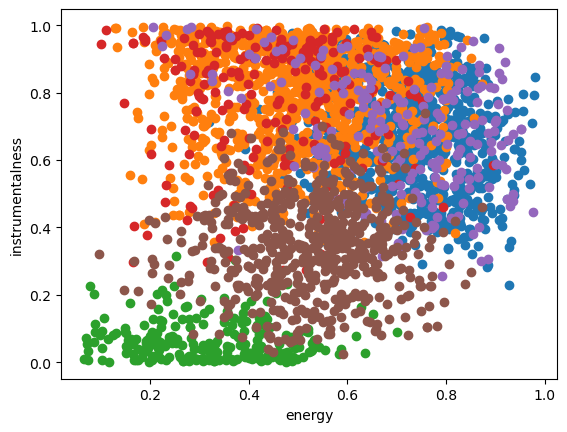

In [18]:
kmeans = KMeans(n_clusters=6, random_state=1234)
kmeans.fit(audio_features_scaled)
# assign a cluster to each example
labels = kmeans.predict(audio_features_scaled)
# retrieve unique clusters
clusters = np.unique(labels)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(labels == cluster)
    # create scatter of these samples
    pyplot.scatter(audio_features.to_numpy()[row_ix, 0], audio_features.to_numpy()[row_ix,1])
    pyplot.xlabel("energy")
    pyplot.ylabel("instrumentalness")
    # show the plot
pyplot.show()

In [19]:
clusters = kmeans.predict(audio_features_scaled)
# clusters
pd.Series(clusters).value_counts().sort_index()

0     909
1    1043
2     244
3     204
4     233
5     586
dtype: int64

In [20]:
# saving with pickle
import pickle

# scaler = StandardScaler()
# model = KMeans()

with open("scaler_song_recommender.pickle", "wb") as f:
    pickle.dump(scaler,f)

with open("kmeans_song_recommender.pickle", "wb") as f:
    pickle.dump(kmeans,f)

In [21]:
# getting the scaled songs back into a Pandas dataframe
scaled_songs_df = pd.DataFrame(audio_features_scaled, columns=["danceability", "energy", "loudness", "speechiness", "acousticness", "liveness", "valence", "tempo"])
scaled_songs_df.head()

,danceability,energy,loudness,speechiness,acousticness,liveness,valence,tempo
0,-0.773027,0.241950,-0.104877,0.088937,-0.858209,-0.345789,-0.565633,1.534297
1,-1.314026,1.378859,0.801107,1.896226,-0.851157,-0.501234,-1.065189,0.739340
2,-1.401460,0.914435,0.590421,-0.199622,-0.856228,0.184866,-0.944995,-0.333773
3,-0.609087,1.059336,0.882167,0.650867,0.196259,0.334951,-0.017249,0.645011
4,-0.789421,1.152221,0.605795,-0.126723,-0.803023,0.356392,-0.505536,-0.693029


In [22]:
scaled_songs_df

,danceability,energy,loudness,speechiness,acousticness,liveness,valence,tempo
0,-0.773027,0.241950,-0.104877,0.088937,-0.858209,-0.345789,-0.565633,1.534297
1,-1.314026,1.378859,0.801107,1.896226,-0.851157,-0.501234,-1.065189,0.739340
2,-1.401460,0.914435,0.590421,-0.199622,-0.856228,0.184866,-0.944995,-0.333773
3,-0.609087,1.059336,0.882167,0.650867,0.196259,0.334951,-0.017249,0.645011
4,-0.789421,1.152221,0.605795,-0.126723,-0.803023,0.356392,-0.505536,-0.693029
...,...,...,...,...,...,...,...,...
3214,1.248889,-0.590298,0.133237,0.468619,-0.029320,4.135305,0.869181,-0.995490
3215,-0.089947,1.256252,0.873607,-0.088755,-0.801559,3.969140,-1.192895,-0.045810
3216,0.095851,-0.501129,-0.651681,-0.600567,0.164033,2.521897,1.023180,0.338140
3217,0.363618,0.349696,0.305838,-0.545893,-0.416025,-0.613798,0.508600,-0.539294


# Scaling the audio features of song provided by the user

In [23]:
# seaching spotify for song provided by the user
# todo: add artist to be more specific
user_song = "anyway the wind blows"
result = sp.search(q=user_song,limit=1)

In [24]:
# getting the id of a song
result["tracks"]["items"][0]["id"]

'61lKkMxzobo0H9nJjzMicx'

In [25]:
# getting the audio features of a song using the song id
user_song_audio_features = sp.audio_features(result["tracks"]["items"][0]["id"])
user_song_audio_features

[{'danceability': 0.451,
  'energy': 0.721,
  'key': 2,
  'loudness': -13.575,
  'mode': 1,
  'speechiness': 0.0374,
  'acousticness': 0.37,
  'instrumentalness': 0,
  'liveness': 0.233,
  'valence': 0.764,
  'tempo': 129.503,
  'type': 'audio_features',
  'id': '61lKkMxzobo0H9nJjzMicx',
  'uri': 'spotify:track:61lKkMxzobo0H9nJjzMicx',
  'track_href': 'https://api.spotify.com/v1/tracks/61lKkMxzobo0H9nJjzMicx',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/61lKkMxzobo0H9nJjzMicx',
  'duration_ms': 175827,
  'time_signature': 4}]

In [26]:
# creating a Pandas dataframe with the audio features of the user song
user_song_df = pd.DataFrame(user_song_audio_features)    
user_song_df = user_song_df[["danceability","energy","loudness","speechiness","acousticness",
    "instrumentalness","liveness","valence","tempo","id","duration_ms"]]

user_song_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms
0,0.451,0.721,-13.575,0.0374,0.37,0,0.233,0.764,129.503,61lKkMxzobo0H9nJjzMicx,175827


In [27]:
user_song_audio_features = user_song_df[["danceability", "energy", "loudness", "speechiness", "acousticness", "liveness", "valence", "tempo"]]

In [28]:
# scaling the song provided by the user
user_song_audio_features_scaled = scaler.transform(user_song_audio_features)
user_song_audio_features_scaled

array([[-0.62001673,  0.37570371, -0.79039127, -0.52766794,  0.22555457,
         0.1902266 ,  1.07200837,  0.36039947]])

In [29]:
# use kmeans.predict() to predict what cluster the song by user belongs to
label = kmeans.predict(user_song_audio_features_scaled)
label = int(label)

In [30]:
# including the "clusters", "id" and "duration_ms" columns to the scaled_songs_df
scaled_songs_df["clusters"] = clusters
scaled_songs_df = scaled_songs_df.join(songs_df[["id", "duration_ms"]])
scaled_songs_df

,danceability,energy,loudness,speechiness,acousticness,liveness,valence,tempo,clusters,id,duration_ms
0,-0.773027,0.241950,-0.104877,0.088937,-0.858209,-0.345789,-0.565633,1.534297,1,3q9G9SvgdfE1fxlvoDIb20,167720
1,-1.314026,1.378859,0.801107,1.896226,-0.851157,-0.501234,-1.065189,0.739340,1,47FyQCd3TYLrZ9TU6MPaWK,166707
2,-1.401460,0.914435,0.590421,-0.199622,-0.856228,0.184866,-0.944995,-0.333773,1,6p8eFfPw3nQkf37aT3AkmK,438120
3,-0.609087,1.059336,0.882167,0.650867,0.196259,0.334951,-0.017249,0.645011,1,2b9lp5A6CqSzwOrBfAFhof,296200
4,-0.789421,1.152221,0.605795,-0.126723,-0.803023,0.356392,-0.505536,-0.693029,1,1s4Ie0cT6P73SRSfh3oyGW,291373
...,...,...,...,...,...,...,...,...,...,...,...
3214,1.248889,-0.590298,0.133237,0.468619,-0.029320,4.135305,0.869181,-0.995490,3,2Ed07HGaDuZGrDYAFG1BdC,231547
3215,-0.089947,1.256252,0.873607,-0.088755,-0.801559,3.969140,-1.192895,-0.045810,3,0sLR4zxufrMibvjc2G5FEc,306827
3216,0.095851,-0.501129,-0.651681,-0.600567,0.164033,2.521897,1.023180,0.338140,3,3GGt2kbKX4VFCs3VM5JcsH,314400
3217,0.363618,0.349696,0.305838,-0.545893,-0.416025,-0.613798,0.508600,-0.539294,0,0Klcv9pnAMm5UjNh6PcCJQ,337760


In [31]:
# saving a csv file of the scaled_songs_df
scaled_songs_df.to_csv("scaled_songs_df.csv", index=False)

In [32]:
# including the "id" and "duration_ms" columns to the scaled_user_song_df
scaled_user_song_df = pd.DataFrame(user_song_audio_features_scaled, columns=["danceability", "energy", "loudness", "speechiness", "acousticness", "liveness", "valence", "tempo"])
scaled_user_song_df = scaled_user_song_df.join(user_song_df[["id", "duration_ms"]])
scaled_user_song_df.head()

,danceability,energy,loudness,speechiness,acousticness,liveness,valence,tempo,id,duration_ms
0,-0.620017,0.375704,-0.790391,-0.527668,0.225555,0.190227,1.072008,0.360399,61lKkMxzobo0H9nJjzMicx,175827


In [33]:
scaled_songs_df.head()

,danceability,energy,loudness,speechiness,acousticness,liveness,valence,tempo,clusters,id,duration_ms
0,-0.773027,0.241950,-0.104877,0.088937,-0.858209,-0.345789,-0.565633,1.534297,1,3q9G9SvgdfE1fxlvoDIb20,167720
1,-1.314026,1.378859,0.801107,1.896226,-0.851157,-0.501234,-1.065189,0.739340,1,47FyQCd3TYLrZ9TU6MPaWK,166707
2,-1.401460,0.914435,0.590421,-0.199622,-0.856228,0.184866,-0.944995,-0.333773,1,6p8eFfPw3nQkf37aT3AkmK,438120
3,-0.609087,1.059336,0.882167,0.650867,0.196259,0.334951,-0.017249,0.645011,1,2b9lp5A6CqSzwOrBfAFhof,296200
4,-0.789421,1.152221,0.605795,-0.126723,-0.803023,0.356392,-0.505536,-0.693029,1,1s4Ie0cT6P73SRSfh3oyGW,291373


In [34]:
# creating a sample dataframe based on matching the clusters (could probably be done more efficiently)
sample_df = scaled_songs_df.loc[scaled_songs_df["clusters"]== label]
sample_df.head()

,danceability,energy,loudness,speechiness,acousticness,liveness,valence,tempo,clusters,id,duration_ms
24,-0.002513,0.687797,0.536964,-0.448694,-0.683203,-0.720465,1.346201,-0.177709,0,7dQ7jYmdsCRWXyjjgwaLy7,378107
25,-0.089947,1.018466,0.471801,-0.442619,-0.855733,-0.667935,1.582832,1.083886,0,4yEvEw6cvs9MpSfQUToJG9,259808
63,0.451052,-0.393382,-0.174581,-0.195066,-0.666505,1.074653,-0.347782,-1.386778,0,1DIXPcTDzTj8ZMHt3PDt8p,240693
64,0.440123,0.650643,-0.531838,-0.295302,0.158174,-0.501234,0.211871,-0.254682,0,4RvWPyQ5RL0ao9LPZeSouE,251489
68,0.046669,1.048190,0.246790,-0.275559,-0.805660,-0.561268,1.492687,-1.230256,0,2WfaOiMkCvy7F5fcp2zZ8L,225280


In [35]:
# taking the sample song
rec_song_df = sample_df.sample(1)
rec_song_df

,danceability,energy,loudness,speechiness,acousticness,liveness,valence,tempo,clusters,id,duration_ms
1500,1.467475,0.264242,0.572951,0.924238,-0.45118,-0.35651,1.455126,-0.292852,0,1dKe9VEGUSNfzn5MDvm6SJ,168873


In [36]:
# isolate track_id
rec_song_id = rec_song_df["id"].to_string(index=False)
rec_song_id

'1dKe9VEGUSNfzn5MDvm6SJ'

In [37]:
# embed the Spotify player and passs it the rec_song_id
from IPython.display import IFrame

IFrame(src="https://open.spotify.com/embed/track/"+rec_song_id,
       width="320",
       height="80",
       frameborder="0",
       allowtransparency="true",
       allow="encrypted-media",
       )